# MCMC CALIBRATION TECHNICS IN CONTEXT OF  INFECTIOUS DISEASE MODELING

## Prerequies

In [ ]:
# pip install summerepi2 estival jax==0.4.24 jaxlib==0.4.24 nevergrad jupyter pymc numpyro

In [ ]:
# pip install multiprocess
# %pip install --upgrade --force-reinstall multiprocess


In [1]:
# This is required for pymc parallel evaluation in notebooks

import multiprocess as mp
import platform

if platform.system() != "Windows":
    
    mp.set_start_method('forkserver')

In [2]:
import Calibrate as cal #Runing the calibration process and gathering results
from calibs_utilities import get_all_priors, get_targets, load_data
from models.models import model1 #All the models we design for the test
#from Calibrate import plot_comparison_bars

# Combining tagets and prior with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel


import pandas as pd
import plotly.express as px
pd.options.plotting.backend = "plotly" #To allow plotly graphic
import matplotlib.pyplot as plt

import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Calibration Data
If data are needed to define a target, we just need to import it from our file data which we will design correctly.
In this example we import data from a YAML file.

In [3]:
#An example of data for the calibration 

output_labels = {"index": "time", "value": "number infectious"}

targets_yml = './data/target_yml.yml'
targets = load_data(targets_yml)
targets_data = targets['active_cases']

targets_data.plot(kind="scatter",labels=output_labels)



In [7]:


#Names of parameters and their ranges
params = {
    "contact_rate": (0.0,0.5),
    "recovery_rate": (0.0,0.8)

}
params
targets = get_targets(targets_yml)
priors = get_all_priors(params)

## Model Definition and Configuration

A mechanistic model (ODE-Based) model discribing Infectious Disease transmission.

In [8]:
model_1 = model1()

## Trial run 

In [9]:
parameters = {
    "contact_rate": 0.3,
    "recovery_rate": 0.1,
    #"active_cases_dispersion": 0.5,
}

model_1.run(parameters)


pd.DataFrame(
    {
        "modelled": model_1.get_outputs_df()["infectious"],
        "observed": targets_data,
    }
).plot(kind="scatter", labels=output_labels)

## Sampling 

In [10]:
#Defining  a Bayesian Compartmental Model
bcm = BayesianCompartmentalModel(model_1, parameters, priors, targets)

In [11]:
bcm.priors

{'contact_rate': UniformPrior contact_rate {bounds: (0.0, 0.5)},
 'recovery_rate': UniformPrior recovery_rate {bounds: (0.0, 0.8)}}

In [12]:
initial_parameters = {
"contact_rate": 0.15,
"recovery_rate": 0.1,
#"active_cases_dispersion": (0.5,1),
}
# #bcm.run(initial_parameters)
# for param, ranges in initial_parameters.items():
#     print(param)
#     print(ranges)


In [13]:
samplers = [pm.DEMetropolisZ] + [pm.DEMetropolis] + [pm.Metropolis]


In [15]:

samplers = [pm.DEMetropolisZ] + [pm.DEMetropolis] + [pm.Metropolis]
results = []
for sampler in samplers:
    #print(sampler)
    idata, Time = cal.Sampling_calib(
        bcm_model = bcm,
        mcmc_algo = sampler,
        initial_params = initial_parameters,
        draws = 4000,
        tune = 1000)
    results.append(cal.Compute_metrics(
        mcmc_algo = sampler,
        idata = idata ,
        Time = Time,
                    ))


Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [contact_rate, recovery_rate]
Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 54 seconds.
Population sampling (4 chains)
DEMetropolis: [contact_rate, recovery_rate]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.
Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 54 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [contact_rate]
>Metropolis: [recovery_rate]
Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.or

In [16]:
results_df = pd.concat(results)
# results
results_df = results_df.reset_index(drop=True)
results_df.style.set_caption("MCMC COMPARISON")
# print(results_df.Sampler)

,Sampler,Time,Mean_ESS,Ess_per_sec,Mean_Rhat,Min_Ess,Rhat_max,Trace
0,DEMetropolisZ,59.674102,655.357926,10.982284,1.004877,639.038394,1.004995,Inference data with groups: > posterior > sample_stats
1,DEMetropolis,60.288351,1087.766644,18.042733,1.002652,1080.955908,1.002796,Inference data with groups: > posterior > sample_stats
2,metropolis,64.196515,5.341444,0.083205,2.027434,5.326206,2.035425,Inference data with groups: > posterior > sample_stats


## Using arviz for trace visualization

Sampler =  DEMetropolisZ


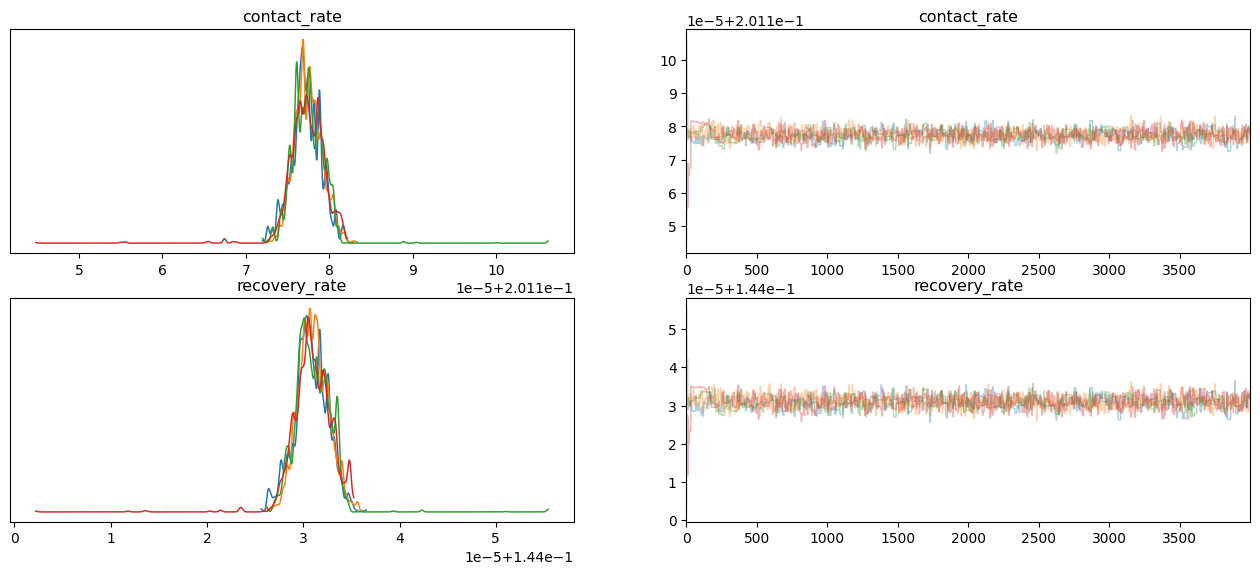

Sampler =  DEMetropolis


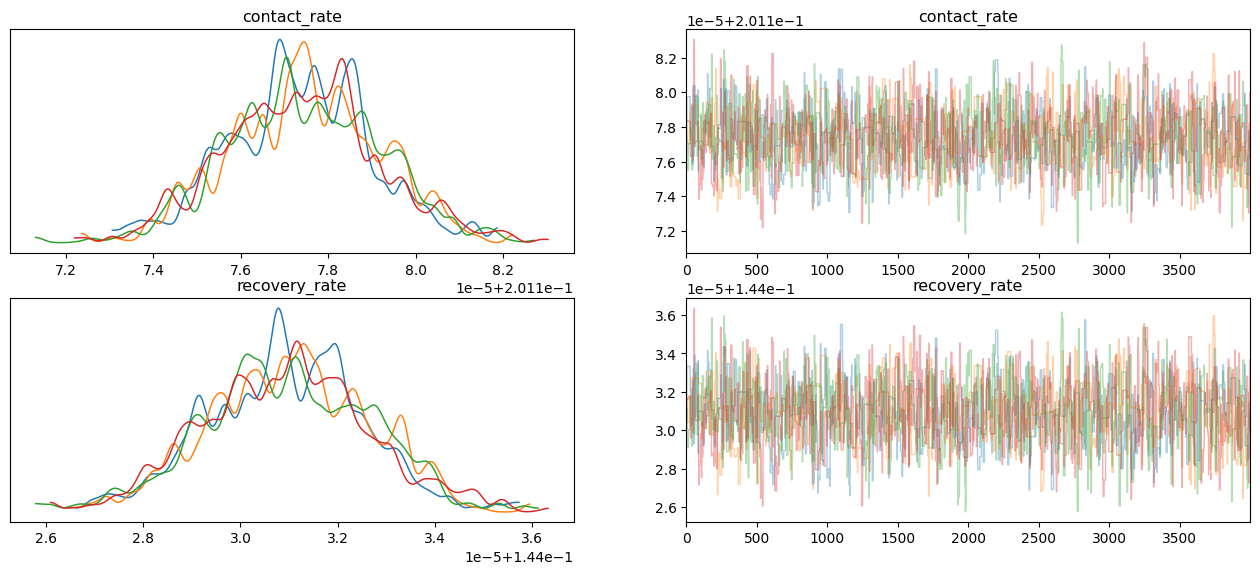

Sampler =  metropolis


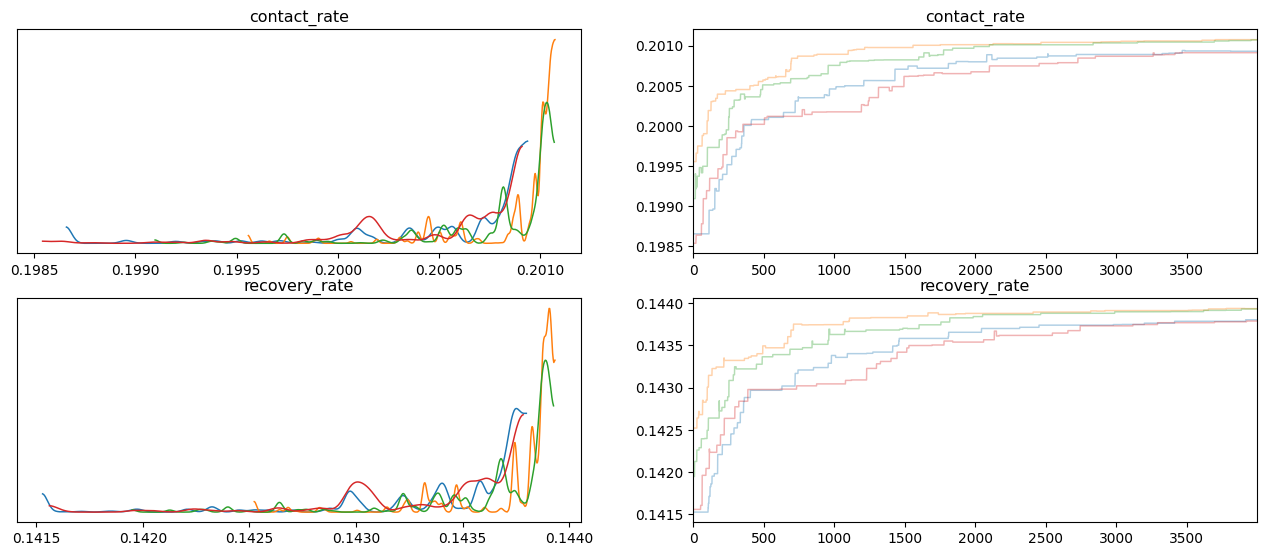

In [17]:
import arviz as az
for idata, sampler in zip(results_df.Trace, results_df.Sampler):
    subset = idata.sel(draw=slice(0, None), groups="posterior")
    print("Sampler = ",sampler)
    az.plot_trace(subset, figsize=(16,3.2*len(subset.posterior)),compact=False)#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
    plt.show()



In [18]:
from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling import tools as esamptools

## Computing the likelihood function for each sampler

In [19]:
map_res = []
for idata, sampler in zip(results_df.Trace, results_df.Sampler):
    if (sampler == "metropolis"):
        print(sampler)
        likelihood_df = likelihood_extras_for_idata(idata, bcm)
        ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
        map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
        map_res.append(bcm.run(map_params))
        



metropolis


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
model_1.run(map_params)

pd.DataFrame(
    {
        "DEMetropolisZ": map_res[0].derived_outputs["active_cases"],
        "DEMetropolis": map_res[1].derived_outputs["active_cases"],
        "observed": targets_data,
    }
).plot(kind="scatter", labels=output_labels)
